## Data Preparation

In [1]:
# Import all the needed package here
import gurobipy as gp
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# read all the training and testing dataset here
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
# Data Preparation for training set
y_train = train["y"]
x_train = train.drop(columns=["y"])

# Adding an intercept term to the input data
x_train_gp = x_train.copy(deep=True)
x_train_gp.insert(0, 'Intercept', 1)

# Data Preparation for testing set
y_test = test["y"]
x_test = test.drop(columns=["y"])

# Adding an intercept term to the input data
x_test_gp = x_test.copy(deep=True)
x_test_gp.insert(0, 'Intercept', 1)

## Model Implementation and Optimization

In [4]:
# Define the range of variables to be selected and other initial settings
start = 5
max_value = x_train_gp.shape[1] - 1
variable_range = range(start, max_value + 1, 5)
if max_value % 5 != 0:
    variable_range = [*variable_range, max_value]
splits = 10
results_df = pd.DataFrame(columns=['var_num', 'fold', 'train_mse', 'val_mse'] + \
                          [f'b{i}' for i in range(x_train_gp.shape[1])])

# Setup KFold cross-validation
kf = KFold(n_splits=splits, shuffle=True, random_state=42)

### MIQP model implementation

In [5]:
# Start timing the process
start_time = time.time()

# Iterate over the range of variables
for var_num in variable_range:

    # Perform cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(x_train_gp, y_train)):
        # Split data into training and validation sets
        x_fold_train = x_train_gp.iloc[train_idx].reset_index(drop=True)
        y_fold_train = y_train.iloc[train_idx].reset_index(drop=True)
        x_fold_val = x_train_gp.iloc[test_idx].reset_index(drop=True)
        y_fold_val = y_train.iloc[test_idx].reset_index(drop=True)

        # Set up the Gurobi model for linear regression with variable selection
        lr_gp = gp.Model()
        # Setting up decision variables that represent the coefficients of regression
        betas = lr_gp.addMVar(x_fold_train.shape[1], lb=-np.inf)
        # Setting up binary variables to represent te usage of all variables
        betas_m = lr_gp.addMVar(x_fold_train.shape[1], vtype="B")

        # Setting up big M constraints to ensure betas_m[i] is 1 when betas[i] is not 0 
        lr_gp.addConstrs(100 * betas_m[i] >= betas[i] for i in range(1, x_fold_train.shape[1]))
        lr_gp.addConstrs(100 * betas_m[i] >= -1 * betas[i] for i in range(1, x_fold_train.shape[1]))

        # Constraint on the number of variables
        lr_gp.addConstr(gp.quicksum(betas_m[i] for i in range(1, x_fold_train.shape[1])) <= var_num)

        # Objective function: minimize the sum of squared errors
        lr_gp.setObjective(gp.quicksum((gp.quicksum(betas[i]*x_fold_train.iloc[j,i] for i \
                                                    in range(x_fold_train.shape[1]))-y_fold_train[j])\
                                      *(gp.quicksum(betas[i]*x_fold_train.iloc[j,i] for i \
                                                   in range(x_fold_train.shape[1]))-y_fold_train[j])\
                        for j in range(x_fold_train.shape[0])))

        # Tell Gurobi to shup up!!
        lr_gp.Params.OutputFlag = 0

        # Optimize the model
        lr_gp.optimize()

        # Calculate the validation error
        predicted_values = np.dot(x_fold_val, betas.x)
        residuals = y_fold_val - predicted_values
        validation_sse = np.sum(residuals**2)

        # Record the results
        data_row = [var_num, fold, lr_gp.objVal / x_fold_train.shape[0], \
                    validation_sse / x_fold_val.shape[0]] + list(betas.x)
        results_df = pd.concat([results_df, pd.DataFrame([data_row], columns=results_df.columns)]\
                               , ignore_index=True)
        results_df.to_csv("results_df.csv",index=False)

# Print total time taken
print(time.time() - start_time)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20
3499.80926156044


In [6]:
# read the result
results_df = pd.read_csv("results_df.csv")
results_df

,var_num,fold,train_mse,val_mse,b0,b1,b2,b3,b4,b5,...,b41,b42,b43,b44,b45,b46,b47,b48,b49,b50
0,5,0,3.340108,4.843393,1.033162,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.890246,0.000000,0.879715,0.000000,0.000000,0.000000
1,5,1,3.532754,3.050839,1.065971,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.899255,0.000000,0.890220,0.000000,0.000000,0.000000
2,5,2,3.544048,3.056338,1.093073,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.933499,0.000000,0.895513,0.000000,0.000000,0.000000
3,5,3,3.558526,2.905611,0.993298,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.889633,0.000000,0.812750,0.000000,0.000000,0.000000
4,5,4,3.368634,4.758383,1.089829,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.817658,0.000000,0.889687,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,50,5,2.096472,2.694549,0.927139,-0.188593,-0.041313,0.314904,0.396405,-0.112112,...,-0.779398,0.335927,-0.561300,-0.070650,1.927950,-0.039312,1.177802,0.238812,0.719959,-0.307943
96,50,6,2.060630,3.002748,0.971601,-0.077454,-0.006450,0.350662,0.343386,0.074494,...,-0.750680,0.526879,-0.716178,0.049086,1.889483,0.005110,1.091513,0.332626,0.690245,-0.317265
97,50,7,2.097745,2.542203,1.012705,-0.165677,0.233782,0.465149,0.483190,0.097638,...,-1.018681,0.566537,-0.815869,-0.116420,1.938404,-0.041275,1.069913,0.481768,0.815044,-0.227825
98,50,8,1.943516,4.163277,0.996242,-0.010889,0.090357,0.428021,0.260775,-0.124489,...,-0.375543,0.342595,-0.340528,0.284155,1.929303,-0.060314,1.082921,-0.024157,0.442727,-0.170216


### Verifying that no coefficients are close to the specified big M value

In [7]:
# verify that no coefficients are close to the big M value
columns_to_check = ['b{}'.format(i) for i in range(51)]

# Create a boolean mask for the specified condition for each column
mask = results_df[columns_to_check].apply(lambda col: (col >= 100 * 0.999) & (col <= 100 * 1.001))

# Use any(axis=1) to check if any column in a row satisfies the condition
filtered_df = results_df[mask.any(axis=1)]

# Display the rows where any of the specified columns are within 0.1% of 10
print(filtered_df)

Empty DataFrame
Columns: [var_num, fold, train_mse, val_mse, b0, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, b14, b15, b16, b17, b18, b19, b20, b21, b22, b23, b24, b25, b26, b27, b28, b29, b30, b31, b32, b33, b34, b35, b36, b37, b38, b39, b40, b41, b42, b43, b44, b45, b46, b47, b48, b49, b50]
Index: []

[0 rows x 55 columns]


In [8]:
# Calculate the average MSE for training and validation sets for each number of variables
mse_table = results_df[["var_num", "train_mse", "val_mse"]].groupby("var_num").mean().reset_index()
mse_table

,var_num,train_mse,val_mse
0,5,3.472173,3.656458
1,10,2.370374,2.815864
2,15,2.233374,3.117865
3,20,2.152988,3.173691
4,25,2.103267,3.130505
5,30,2.071979,3.255929
6,35,2.052923,3.269304
7,40,2.040867,3.323356
8,45,2.034732,3.358445
9,50,2.034079,3.361816


### Visualization

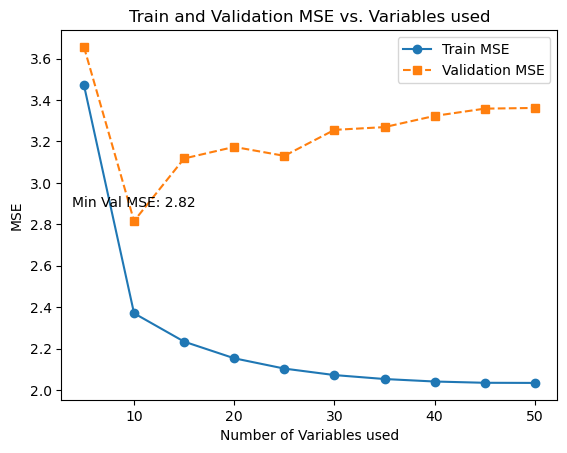

In [9]:
# Plotting MSE against the number of variables
plt.plot(mse_table['var_num'], mse_table['train_mse'], label='Train MSE', marker='o', linestyle='-')
plt.plot(mse_table['var_num'], mse_table['val_mse'], label='Validation MSE', marker='s', linestyle='--')

# Annotating the plot with the minimum validation MSE
min_val_mse_index = mse_table['val_mse'].idxmin()
min_val_mse_var_num = mse_table.loc[min_val_mse_index, 'var_num']
min_val_mse_value = mse_table.loc[min_val_mse_index, 'val_mse']
plt.annotate(f'Min Val MSE: {min_val_mse_value:.2f}', (min_val_mse_var_num, min_val_mse_value), 
             textcoords="offset points", xytext=(0,10), ha='center')

# Setting plot labels and title
plt.xlabel('Number of Variables used')
plt.ylabel('MSE')
plt.title('Train and Validation MSE vs. Variables used')
plt.legend()
plt.show()

In [10]:
# Fit the final MIQP model with the optimal number of variables
lr_gp = gp.Model()
betas = lr_gp.addMVar(x_train_gp.shape[1], lb=-np.inf)
betas_m = lr_gp.addMVar(x_train_gp.shape[1], vtype="B")
residuals = lr_gp.addMVar(x_train_gp.shape[0], lb=-np.inf)

# Adding constraints similar to previous model
lr_gp.addConstrs(100 * betas_m[i] >= betas[i] for i in range(1, x_train_gp.shape[1]))
lr_gp.addConstrs(100 * betas_m[i] >= -1 * betas[i] for i in range(1, x_train_gp.shape[1]))
lr_gp.addConstr(gp.quicksum(betas_m[i] for i in range(1, x_train_gp.shape[1])) <= int(min_val_mse_var_num))

# Objective function for the final model
lr_gp.addConstrs(residuals[j] == (gp.quicksum(betas[i] * x_train_gp.iloc[j, i] for i in range(x_train_gp.shape[1])) - y_train[j]) 
                 for j in range(x_train_gp.shape[0]))
lr_gp.setObjective(gp.quicksum(residuals[i] * residuals[i] for i in range(x_train_gp.shape[0])))
lr_gp.Params.OutputFlag = 0 # tell gurobi to shut up!!
lr_gp.optimize()

### Lasso model implementation

In [11]:
scaler = StandardScaler()
x_train_lasso = scaler.fit_transform(x_train)
x_test_lasso = scaler.transform(x_test)

alphas = np.linspace(0.001, 100, 20000)

# Perform LassoCV for various alpha values
mse_values = []
zero_coeffs = []
lasso_coefs=[]

# Iterate over alphas to save the mse_values and zero_coeffs for all values of alpha
for alpha in alphas:
    lasso = LassoCV(alphas=[alpha], cv=splits)
    lasso.fit(x_train_lasso, y_train)
    mse_values.append(lasso.mse_path_.mean())
    zero_coeffs.append(np.sum(lasso.coef_ != 0))
    coef_list = lasso.coef_.tolist()
    lasso_coefs.append(coef_list)

# Retrain lasso object to get the lasso model with least CV error
lasso_cv = LassoCV(alphas=alphas, cv=10)  
lasso_cv.fit(x_train_lasso, y_train)

# Find the best alpha value and corresponding MSE
best_alpha = alphas[np.argmin(mse_values)]
best_mse = np.min(mse_values)
best_var = zero_coeffs[np.argmin(mse_values)]

### Visualization

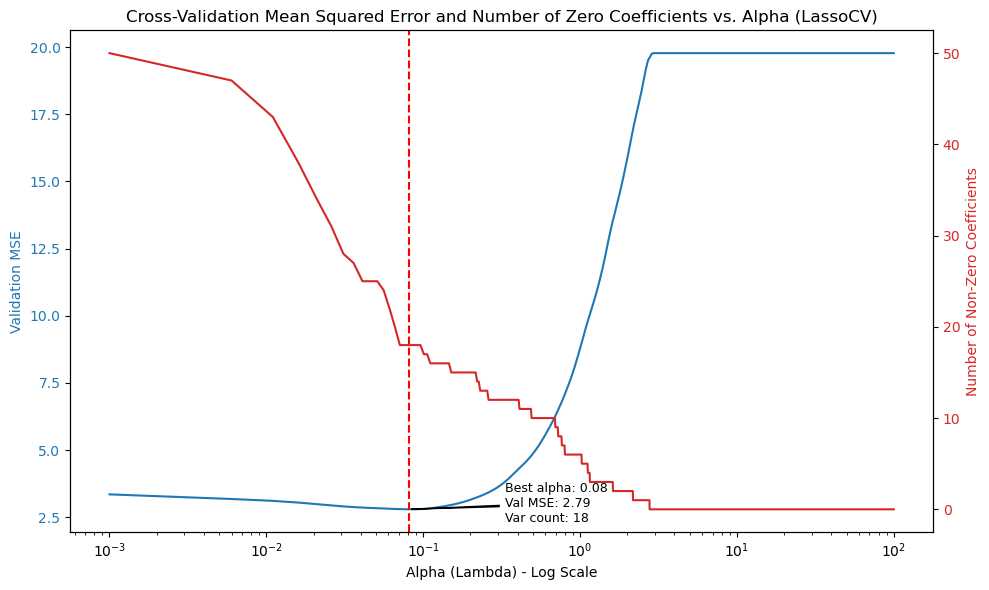

In [12]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MSE on the primary y-axis
ax1.plot(alphas, mse_values, label="MSE", linestyle='-')
ax1.set_xlabel("Alpha (Lambda) - Log Scale")
ax1.set_ylabel("Validation MSE", color='tab:blue')
ax1.set_xscale('log')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for the "Number of Non-Zero Coefficients" plot
ax2 = ax1.twinx()
ax2.plot(alphas, zero_coeffs, label="Number of Non-Zero Coefficients", linestyle='-', color='tab:red')
ax2.set_ylabel("Number of Non-Zero Coefficients", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Plot a red dotted line for the best validation MSE
ax1.axvline(x=best_alpha, color='red', linestyle='--', label=f'Best MSE ({best_alpha:.2e}, {best_mse:.4f})')

# Annotate the point with "Best Val MSE" and the actual value without scientific notation
ax1.annotate(f"Best alpha: {best_alpha:.2f}\nVal MSE: {best_mse:.2f}\nVar count: {best_var:.0f}", 
             xy=(best_alpha, best_mse), xytext=(best_alpha + 0.25, best_mse + 0.2),
             arrowprops=dict(facecolor='black', arrowstyle='wedge,tail_width=0.1', lw=1),
             fontsize=9, ha='left', va='center')

# Title 
plt.title("Cross-Validation Mean Squared Error and Number of Zero Coefficients vs. Alpha (LassoCV)")
fig.tight_layout()
plt.show()

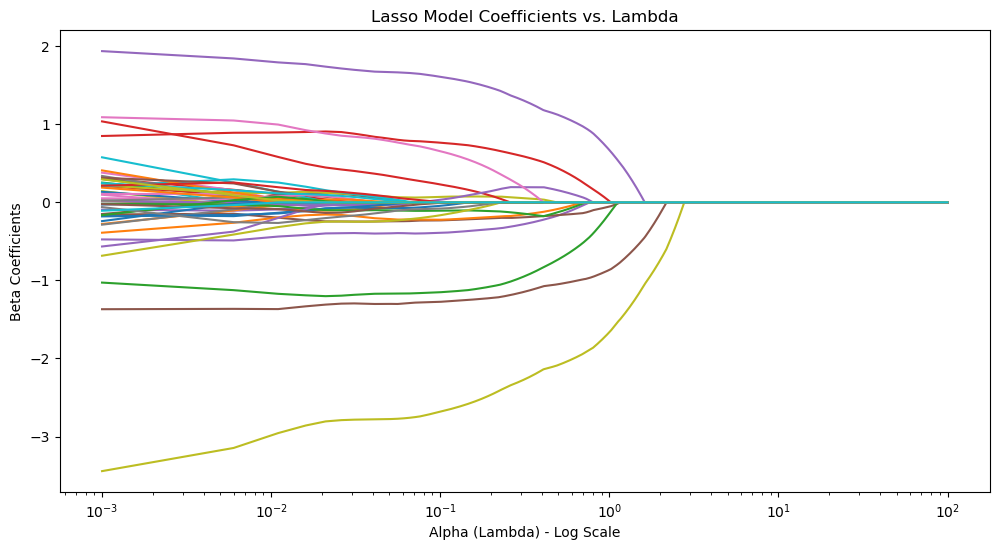

In [13]:
# Plotting
plt.figure(figsize=(12, 6))
lasso_coefs = np.array(lasso_coefs)  # Convert to numpy array for easy transposition
plt.plot(alphas, lasso_coefs)
plt.title("Lasso Model Coefficients vs. Lambda")
plt.xlabel("Alpha (Lambda) - Log Scale")
plt.ylabel("Beta Coefficients")
plt.xscale("log")
plt.show()

In [14]:
# Calculate MSE for Lasso and Gurobi models on test data
mse1 = mean_squared_error(y_test, lasso_cv.predict(scaler.transform(x_test)))
mse2 = mean_squared_error(y_test, np.dot(x_test_gp, betas.x))

# Print the MSE for both models
print(f"Lasso MSE on Test Data: {mse1}")
print(f"MIQP Model MSE on Test Data: {mse2}")

Lasso MSE on Test Data: 2.3551558018825585
MIQP Model MSE on Test Data: 2.3365439645525226


## Comparison of 2 model

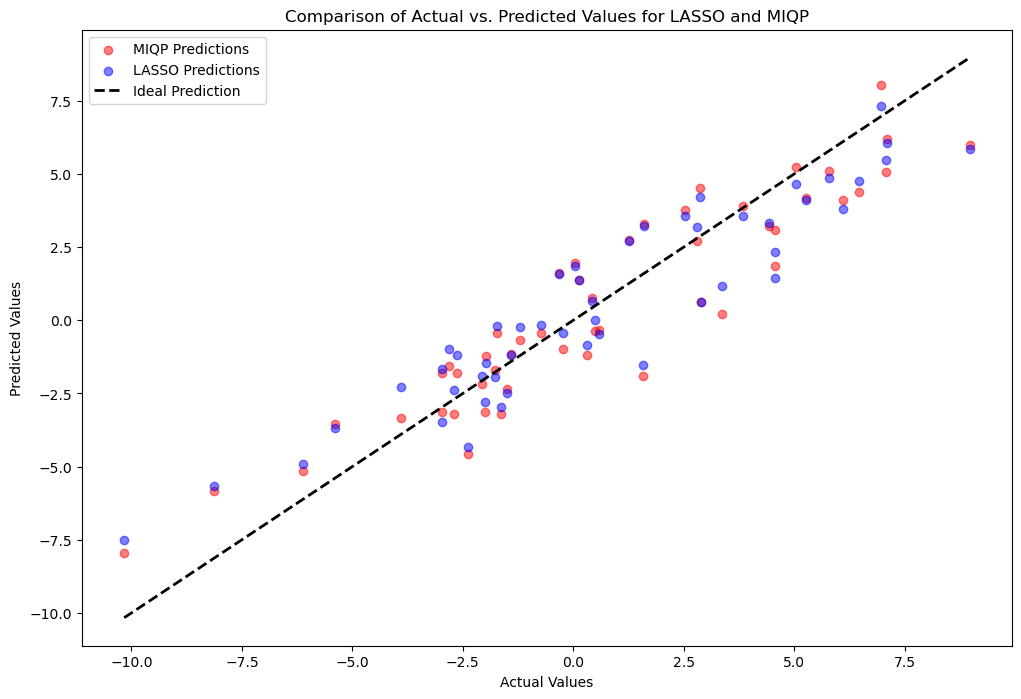

In [15]:
# Generate predictions using MIQP and LASSO
miqp_y_test_pred = np.dot(x_test_gp, betas.x)  # MIQP predictions
lasso_y_test_pred = lasso_cv.predict(x_test_lasso)  # LASSO predictions

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot MIQP predicting result
plt.scatter(y_test, miqp_y_test_pred, alpha=0.5, color='red', label="MIQP Predictions")

# Plot LASSO predicting result
plt.scatter(y_test, lasso_y_test_pred, alpha=0.5, color='blue', label="LASSO Predictions")

# Plot ideal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ideal Prediction")

plt.legend()
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Comparison of Actual vs. Predicted Values for LASSO and MIQP")
plt.show()
